# Spacehip Titanic v2

This is my second approach to this kaggle competition.

In [52]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

## Downloading data

In [53]:
TRAIN_DATASET_PATH = "datasets\\spaceship-titanic\\train.csv"
SUBMISSION_DATASET_PATH = "datasets\\spaceship-titanic\\test.csv"

In [54]:
from sklearn.model_selection import train_test_split

test_ratio = 0.2

dataset = pd.read_csv(TRAIN_DATASET_PATH)
train_set, test_set = train_test_split(dataset, test_size=test_ratio)
X_train, y_train = train_set.drop("Transported", axis=1), train_set["Transported"]
X_test, y_test = test_set.drop("Transported", axis=1), test_set["Transported"]

## Data insight

In [55]:
X_train.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name
5713,6054_01,Mars,True,F/1151/S,TRAPPIST-1e,28.0,NaN,0.0,0.0,0.0,0.0,0.0,Frus Kie
3778,4034_01,Mars,True,E/247/P,TRAPPIST-1e,38.0,False,0.0,0.0,0.0,0.0,0.0,Froon Kité
8490,9072_02,Mars,False,F/1758/S,TRAPPIST-1e,30.0,False,160.0,0.0,719.0,162.0,0.0,Aleys Creke
8212,8776_01,Earth,False,E/574/S,TRAPPIST-1e,40.0,False,0.0,0.0,286.0,6.0,570.0,Winia Headardyer
6257,6623_01,NaN,True,B/218/P,55 Cancri e,38.0,False,NaN,0.0,0.0,0.0,0.0,Saxinon Geraing


In [56]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6954 entries, 5713 to 6676
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   6954 non-null   object 
 1   HomePlanet    6791 non-null   object 
 2   CryoSleep     6775 non-null   object 
 3   Cabin         6787 non-null   object 
 4   Destination   6806 non-null   object 
 5   Age           6812 non-null   float64
 6   VIP           6785 non-null   object 
 7   RoomService   6813 non-null   float64
 8   FoodCourt     6804 non-null   float64
 9   ShoppingMall  6790 non-null   float64
 10  Spa           6808 non-null   float64
 11  VRDeck        6810 non-null   float64
 12  Name          6793 non-null   object 
dtypes: float64(6), object(7)
memory usage: 760.6+ KB


In [57]:
X_train["HomePlanet"].value_counts()

Earth     3680
Europa    1723
Mars      1388
Name: HomePlanet, dtype: int64

In [58]:
X_train["Destination"].value_counts()

TRAPPIST-1e      4707
55 Cancri e      1467
PSO J318.5-22     632
Name: Destination, dtype: int64

In [59]:
print("NaN amount and percentage:")
for column in X_train.columns:
    sum = X_train[column].isnull().sum()
    percent = sum/X_train[column].count()
    print(f"{column:15} {sum:3} \t {percent:.2%}")

NaN amount and percentage:
PassengerId       0 	 0.00%
HomePlanet      163 	 2.40%
CryoSleep       179 	 2.64%
Cabin           167 	 2.46%
Destination     148 	 2.17%
Age             142 	 2.08%
VIP             169 	 2.49%
RoomService     141 	 2.07%
FoodCourt       150 	 2.20%
ShoppingMall    164 	 2.42%
Spa             146 	 2.14%
VRDeck          144 	 2.11%
Name            161 	 2.37%


As we can see there is quite a lot of nan values in each column. We will have to do something with it later.

Let's split the column names into category and numerical columns. This will be helpful later.

In [60]:
cat_cols = []
num_cols = []

for column in X_train.columns:
    if X_train[column].dtype == "object":
        cat_cols.append(column)
    if X_train[column].dtype == "float64":
        num_cols.append(column)

print(cat_cols, num_cols)

['PassengerId', 'HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'VIP', 'Name'] ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']


array([[<AxesSubplot: title={'center': 'Age'}>,
        <AxesSubplot: title={'center': 'RoomService'}>],
       [<AxesSubplot: title={'center': 'FoodCourt'}>,
        <AxesSubplot: title={'center': 'ShoppingMall'}>],
       [<AxesSubplot: title={'center': 'Spa'}>,
        <AxesSubplot: title={'center': 'VRDeck'}>]], dtype=object)

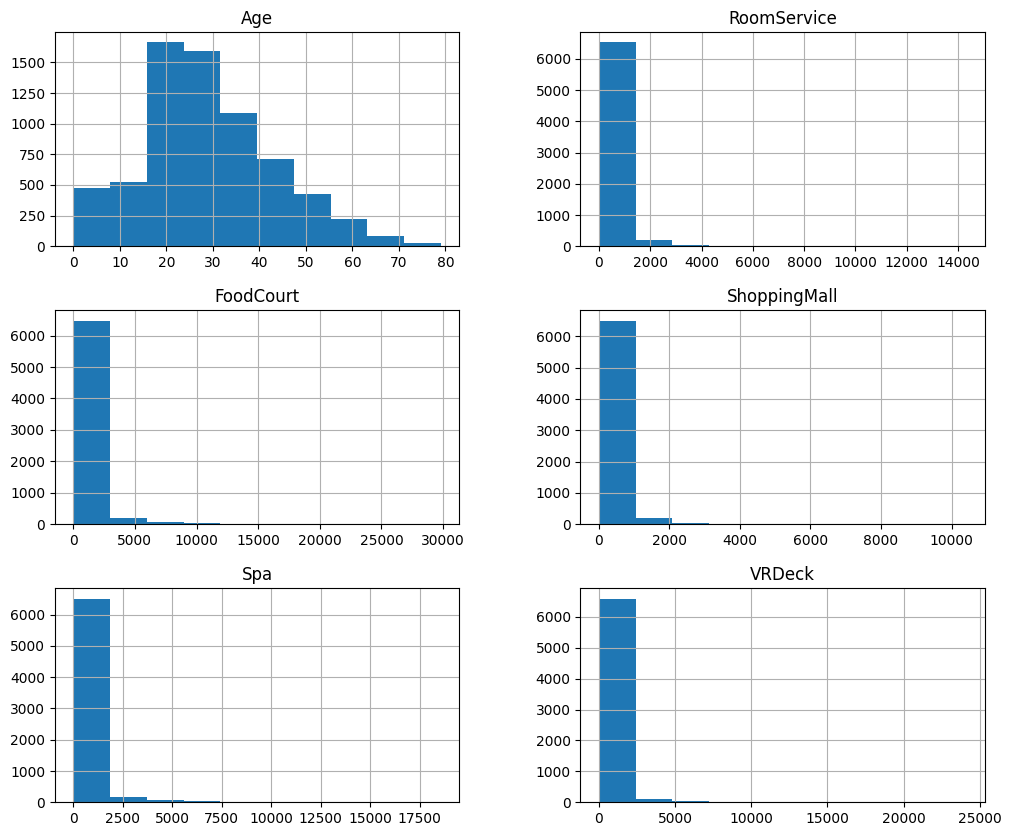

In [61]:
X_train[num_cols].hist(figsize=(12,10))

In [62]:
X_train[num_cols].describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,6812.00000,6813.000000,6804.000000,6790.00000,6808.000000,6810.000000
mean,28.75690,225.111405,469.168577,167.52430,313.382491,320.113950
std,14.42779,670.807408,1646.954806,524.65256,1139.308334,1203.690706
min,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000
25%,19.00000,0.000000,0.000000,0.00000,0.000000,0.000000
50%,27.00000,0.000000,0.000000,0.00000,0.000000,0.000000
75%,37.00000,43.000000,83.000000,25.00000,61.000000,47.000000
max,79.00000,14327.000000,29813.000000,10424.00000,18572.000000,24133.000000


As we cann see the histograms don't look like normal distribution at all. 


In fact this data is exponentially distributed. 

I dont know how to deal with it yet, but I'll try to do something aboit it.

## Data preparation

### Data distribution

<AxesSubplot: >

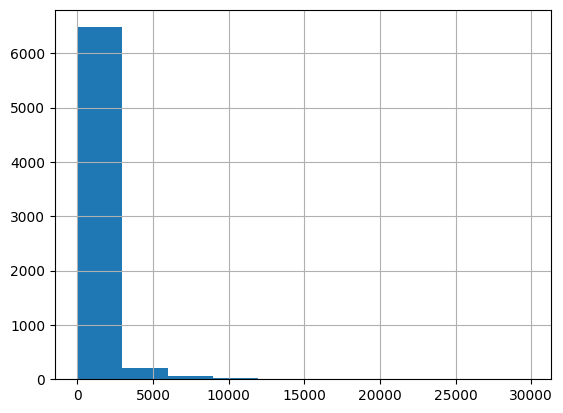

In [63]:
X_train["FoodCourt"].hist()

Percent of -inf values: 63.77%


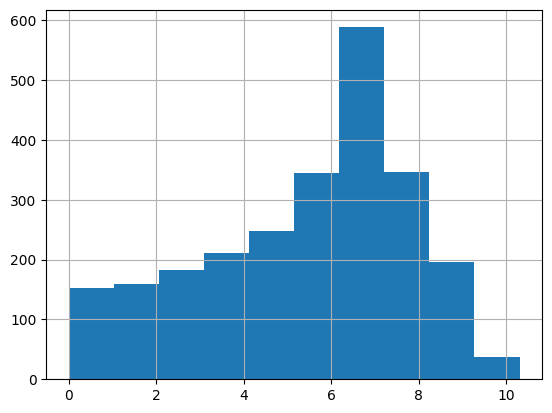

In [64]:
from scipy.stats import boxcox

data = boxcox(X_train["FoodCourt"], 0)
data[data > -np.inf].hist()
inf_perc = data[data == -np.inf].count() / data.count()
print(f"Percent of -inf values: {inf_perc:.2%}")

Boxcox is ineefective because more than half of the records is transformed to -inf.

C:\Users\m.olszanski\AppData\Local\Temp\ipykernel_12092\2932121801.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  X_train[X_train["FoodCourt"] > 0][X_train["FoodCourt"] < 5000]["FoodCourt"].hist()


<AxesSubplot: >

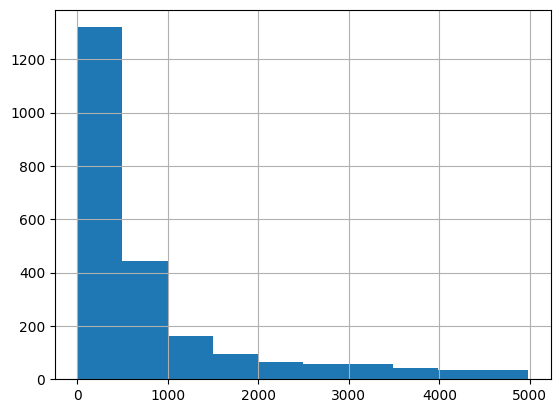

In [65]:
X_train[X_train["FoodCourt"] > 0][X_train["FoodCourt"] < 5000]["FoodCourt"].hist()

In [66]:
corr_matrix = train_set.corr(numeric_only=True)
corr_matrix["Transported"].sort_values(ascending=False)

Transported     1.000000
FoodCourt       0.053590
ShoppingMall    0.008360
Age            -0.076378
VRDeck         -0.210343
Spa            -0.219409
RoomService    -0.244221
Name: Transported, dtype: float64

I will leave this numerical data as they are. I will only Use standard scaler in the pipeline.

Only RoomService, Spa and VRDeck has a significant negative correlation with the label.

### Categorical values
For the categorical values I will use the One-Hot-Encoding. I will also create a custom transformer to extract the "Deck" value from "Cabin"column.

In [167]:
from sklearn.base import BaseEstimator, TransformerMixin
from copy import deepcopy

class SeatInfoAdder(BaseEstimator, TransformerMixin):
    
    def __init__(self, only_deck=True):
        self.only_deck = only_deck
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        
        X_new = deepcopy(X)
        X_new["deck"] =  X_new['Cabin'].str.split('/', expand=True).iloc[:,0]
        
        if self.only_deck:
            return X_new
        else:
            X_new["num"], X_new["side"] = X_new['Cabin'].str.split('/', expand=True).iloc[:, 1:]
            return X_new

We also have to do something with the missing categorical values (for numerical we simply use the median value imputer).

I will implement the transformer that replces missing categorical values with the most frequent ones.

In [168]:
class CategoricalImputer(BaseEstimator, TransformerMixin):
    
    def __init__(self, strategy="most_freq", value=None):
        """ 
        Imputer for replacing missing categorical values.

        Args:
            strategy (str): Strategy that the imputer will use to replace missing values:
                - most_freq - replacing with the most frequent values
                - constant - replacing with the contant value (provided as a second argument)
                - drop - dropping the rows with missing value !!!DOES NOT WORK!!!
            
            value (str): Value that imputer will use to replace value, if the "contant" strategy
                is used.                
        """
        accepteed_strategies = ["most_freq", "constant", "drop"]
        if strategy in accepteed_strategies:
            self.strategy = strategy
        else:
            raise ValueError('Wrong strategy used. Please choose one of the following: "most_freq", "constant", "drop".' )
        
        if self.strategy == "constant" and value is None:
           raise ValueError('Value of "value" argument is None, and when used with "constant" strategy it cannot be None')
        else: 
            self.value = value
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        X_new = deepcopy(X)
        
        for column in X_new.columns:
            mask = X_new[column].isna()
            
            if self.strategy == "most_freq":
                freq_value = X_new[column].mode()[0]
                X_new.loc[mask, column] = freq_value
            elif self.strategy == "constant":
                X_new.loc[mask, column] = self.value
                
        if self.strategy == "drop":
            X_new = X_new.dropna(axis=0)
            
        return X_new

### Creating Transforming Pipeline

In [169]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

num_pipeline = Pipeline([
    ("sim_imp", SimpleImputer()),
    ("std_scaler", StandardScaler()),
])

cat_pipeline = Pipeline([
    ("cat_imp", CategoricalImputer()),
    ("seat_adder", SeatInfoAdder()),
    ("one_hot", OneHotEncoder(handle_unknown="ignore"))
])


transform_pipeline = ColumnTransformer([
    ("num_tr", num_pipeline, num_cols),
    ("cat_tr", cat_pipeline, cat_cols),
])

## Model selection

First I will see, how much F1 score I will achieve using Random Forest Classifier.

In [175]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

forest = RandomForestClassifier()

full_pipeline = Pipeline([
    ("transform", transform_pipeline),
    ("forest_clf", forest)
])

param_grid = [
    # {
    #     "forest_clf__n_estimators": [3000, 5000],
    #     "forest_clf__max_leaf_nodes": [25, 50],
    #     "transform__cat_tr__seat_adder__only_deck": [True, False],
    # },
    {
        "forest_clf__n_estimators": [1000, 1500],
        "forest_clf__max_leaf_nodes": [300, 500, 750],
        "transform__cat_tr__seat_adder__only_deck": [True, False],
    }
]

grid_CV = GridSearchCV(full_pipeline, param_grid, cv=2, verbose=3, scoring="f1")
grid_CV.fit(X_train, y_train)
print(f"Best params: {grid_CV.best_params_}\n Best score: {grid_CV.best_score_}")

Fitting 2 folds for each of 12 candidates, totalling 24 fits
[CV 1/2] END forest_clf__max_leaf_nodes=300, forest_clf__n_estimators=1000, transform__cat_tr__seat_adder__only_deck=True;, score=0.763 total time=  19.4s
[CV 2/2] END forest_clf__max_leaf_nodes=300, forest_clf__n_estimators=1000, transform__cat_tr__seat_adder__only_deck=True;, score=0.739 total time=  20.3s
[CV 1/2] END forest_clf__max_leaf_nodes=300, forest_clf__n_estimators=1000, transform__cat_tr__seat_adder__only_deck=False;, score=0.764 total time=  21.8s
[CV 2/2] END forest_clf__max_leaf_nodes=300, forest_clf__n_estimators=1000, transform__cat_tr__seat_adder__only_deck=False;, score=0.741 total time=  21.0s
[CV 1/2] END forest_clf__max_leaf_nodes=300, forest_clf__n_estimators=1500, transform__cat_tr__seat_adder__only_deck=True;, score=0.763 total time=  31.8s
[CV 2/2] END forest_clf__max_leaf_nodes=300, forest_clf__n_estimators=1500, transform__cat_tr__seat_adder__only_deck=True;, score=0.740 total time=  31.4s
[CV 1/2

In [176]:
best_forest = grid_CV.best_estimator_

In [178]:
import joblib

joblib.dump(best_forest, "models\\16\\best_forest.pkl")

['models\\16\\best_forest.pkl']